# Emsemble modelling

In machine learning, ensemble learning uses several learning algorithms to obtain better predictions. 

We will test this concept today to see if we can get better predictions.

For this, let's train 2 models with different configurations. Then, we will submit the same examples for both models and get their predictions. Then, we will extract the mean of these predictions.

Let's start with imports and preprocessing.

In [1]:
# imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

import numpy as np
from numpy import mean
from numpy import std
from numpy import percentile
import pandas as pd
import scipy

# get data
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

# define get_data function
def get_data(path):
  data = pd.read_csv(path, index_col=0)
  return data

#get the data
data = get_data('/tmp/sentiment.csv')

# clone package repository
!git clone https://github.com/vallantin/atalaia.git

# navigate to atalaia directory
%cd atalaia

# install packages requirements
!pip install -r requirements.txt

# install package
!python setup.py install

# import it
from atalaia.atalaia import Atalaia

# get a list with all the texts
texts = data.text

#start atalaia
atalaia = Atalaia('en')

# get the number of tokens in each sentence
# get the lengths
lens = [len(atalaia.tokenize(t)) for t in texts]
data['lengths'] = lens

#delete outliers
data = data.drop(index = [1228])

# lower everything
data['text'] = [atalaia.lower_remove_white(t) for t in data['text']]

# exclude expand contractions
data['text'] = [atalaia.expand_contractions(t) for t in data['text']]

# exclude punctuation
data['text'] = [atalaia.remove_punctuation(t) for t in data['text']]

# exclude numbers
data['text'] = [atalaia.remove_numbers(t) for t in data['text']]

# exclude stopwords
data['text'] = [atalaia.remove_stopwords(t) for t in data['text']]

# exclude excessive spaces
data['text'] = [atalaia.remove_excessive_spaces(t) for t in data['text']]

--2020-07-16 09:04:01--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 108.177.119.100, 108.177.119.138, 108.177.119.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.119.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/74hidgorpn1pucukfgcoi0c5h7rmci4e/1594890225000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-07-16 09:04:01--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/74hidgorpn1pucukfgcoi0c5h7rmci4e/1594890225000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|10

Then, let's split the dataset.

In [2]:
# split train/test
# shuffle the dataset
data = data.sample(frac=1)

# separate all classes present on the dataset
classes_dict = {}
for label in [0,1]:
  classes_dict[label] = data[data['sentiment'] == label]

# get 80% of each label
size = int(len(classes_dict[0].text) * 0.8)
X_train = list(classes_dict[0].text[0:size])      + list(classes_dict[1].text[0:size])
X_test  = list(classes_dict[0].text[size:])       + list(classes_dict[1].text[size:])
y_train = list(classes_dict[0].sentiment[0:size]) + list(classes_dict[1].sentiment[0:size])
y_test  = list(classes_dict[0].sentiment[size:])  + list(classes_dict[1].sentiment[size:])

# Convert labels to Numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Let's consider the vocab size as the number of words
# that compose 90% of the vocabulary
atalaia    = Atalaia('en')
vocab_size = len(atalaia.representative_tokens(0.9, 
                                               ' '.join(X_train),
                                               reverse=False))
oov_tok = "<OOV>"

# start tokenize
tokenizer = Tokenizer(num_words=vocab_size, 
                      oov_token=oov_tok)

# fit on training
# we don't fit on test because, in real life, our model will have to deal with
# words ir never saw before. So, it makes sense fitting only on training.
# when it finds a word it never saw before, it will assign the 
# <OOV> tag to it.
tokenizer.fit_on_texts(X_train)

# get the word index
word_index = tokenizer.word_index

# transform into sequences
# this will assign a index to the tokens present on the corpus
sequences = tokenizer.texts_to_sequences(X_train)

# define max_length 
max_length = 100

# post: pad or truncate after sentence.
# pre: pad or truncate before sentence.
trunc_type='post'
padding_type='post'

padded = pad_sequences(sequences,
                       maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)

# tokenize and pad test sentences
# thse will be used later on the model for accuracy test
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_test_padded    = pad_sequences(X_test_sequences,
                                 maxlen=max_length, 
                                 padding=padding_type, 
                                 truncating=trunc_type)

And finally, let's build two different networks and train them.

In [3]:
# Model 1
embedding_dim = 16

model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# train the model
num_epochs = 100
history_1 =  model_1.fit(padded, 
                         y_train, 
                         epochs=num_epochs, 
                         validation_data=(X_test_padded, 
                                          y_test))

Epoch 1/100
50/50 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.5835 - val_loss: 0.6827 - val_accuracy: 0.6316
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.4739 - accuracy: 0.8354 - val_loss: 0.8911 - val_accuracy: 0.6742
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.2013 - accuracy: 0.9334 - val_loss: 0.7923 - val_accuracy: 0.7168
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: 0.1138 - accuracy: 0.9623 - val_loss: 0.6487 - val_accuracy: 0.7519
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0611 - accuracy: 0.9830 - val_loss: 0.7174 - val_accuracy: 0.7619
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0328 - accuracy: 0.9893 - val_loss: 0.8147 - val_accuracy: 0.7694
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0201 - accuracy: 0.9950 - val_loss: 0.9396 - val_accuracy: 0.7544
Epoch 8/100
5

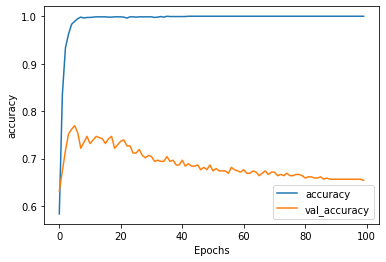

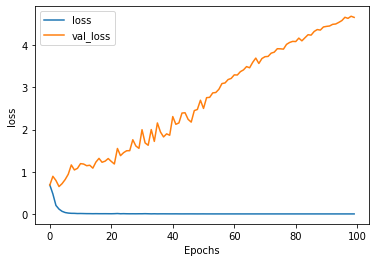

In [4]:
# define the plot function
def plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plots(history_1, "accuracy")
plots(history_1, "loss")

In [5]:
# Model 2
embedding_dim = 16

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# train the model
num_epochs = 100
history_2 = model_2.fit(padded, 
                        y_train, 
                        epochs=num_epochs,
                        validation_data=(X_test_padded, 
                                         y_test))


Epoch 1/100
50/50 [==============================] - 0s 6ms/step - loss: 0.6973 - accuracy: 0.4931 - val_loss: 0.6929 - val_accuracy: 0.5013
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6684 - accuracy: 0.6319 - val_loss: 0.6725 - val_accuracy: 0.6291
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: 0.4146 - accuracy: 0.8593 - val_loss: 0.9061 - val_accuracy: 0.6591
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.2150 - accuracy: 0.9340 - val_loss: 0.8294 - val_accuracy: 0.7368
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 0.1312 - accuracy: 0.9629 - val_loss: 0.7267 - val_accuracy: 0.7393
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0931 - accuracy: 0.9749 - val_loss: 0.7351 - val_accuracy: 0.7569
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0587 - accuracy: 0.9843 - val_loss: 0.8629 - val_accuracy: 0.7569
Epoch 8/100
5

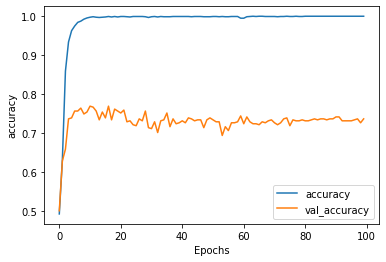

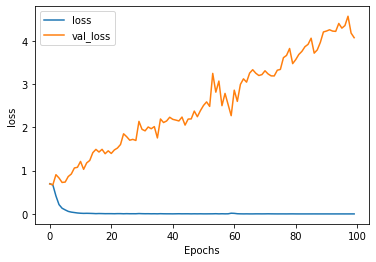

In [6]:
plots(history_2, "accuracy")
plots(history_2, "loss")

Let's calculate the precision and the recall for each one of the models separately.

Then, we will get the average of the predictions made by these two models and compare its recall and precision.

The recall will measure the number of correct positive predictions made out of all possible positive predictions.

The precision will measure the number of correct positive predictions made.

Higher precision will minimize the number of false positives. Higher recall will minimize the number of false negatives.

Since negative comments are more harmful than positive ones, it's important to  minimize the number of false positives (customer is unhappy, but system classify their comment as being a good comment).


In [7]:
# predict
y_pred_1 = model_1.predict(X_test_padded)
y_pred_2 = model_2.predict(X_test_padded)

# get the median
y_pred   = (y_pred_1 + y_pred_2)/2

# round
y_pred   = [1 if y > 0.5 else 0 for y in y_pred]

def get_matrix(y_true, y_pred):
  # confusion matrix
  matrix = tf.math.confusion_matrix(y_true, 
                                    y_pred)

  matrix = np.array(matrix)

  matrix = pd.DataFrame(matrix, 
                        columns=['Positive (predicted)', 'Negative (predicted)'],
                        index=['Positive (real)', 'Negative (real)'])
  
  # print accuracy
  tp = matrix['Positive (predicted)'][0] #true positives
  tn = matrix['Negative (predicted)'][1] #true negatives
  fp = matrix['Positive (predicted)'][1] #false positives
  fn = matrix['Negative (predicted)'][0] #false negatives

  # get recall
  recall = tp/(tp + fn)
  recall = recall * 100
  print('Recall: {:.2f}%'.format(recall))

  # get precision
  precision = tp/(tp + fp)
  precision = precision * 100
  print('Precision: {:.2f}%'.format(precision))

  return matrix

In [8]:
# print matrix for each one of the models, including the ensemble predictions
matrix = get_matrix(y_test, y_pred)
matrix

Recall: 56.78%
Precision: 80.14%


,Positive (predicted),Negative (predicted)
Positive (real),113,86
Negative (real),28,172


In [9]:
get_matrix(y_test, y_pred_1)

Recall: 77.39%
Precision: 64.44%


,Positive (predicted),Negative (predicted)
Positive (real),154,45
Negative (real),85,115


In [10]:
get_matrix(y_test, y_pred_2)

Recall: 82.91%
Precision: 63.71%


,Positive (predicted),Negative (predicted)
Positive (real),165,34
Negative (real),94,106
